**THIS NOTEBOOK CONSISTS THE CODE FOR CNN (NET,ALEXNET & VGG16)**

Setting up Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing OpenCV

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Checking the version of OpenCV

In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


Path for the code folder

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_CODE = 'Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/Code' 
GOOGLE_DRIVE_PATH_CODE = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_CODE)
print(os.listdir(GOOGLE_DRIVE_PATH_CODE))

['Copy of 200033033 Computer Vision Coursework.ipynb', 'Copy of Untitled6.ipynb', '200033033 Computer Vision Coursework.ipynb', 'CNN.ipynb', 'AlexNet.ipynb', 'Copy of Emotion recognition Video.ipynb', 'Emotion recognition Video_part 1.ipynb', 'Copy of Convolutional Neural Network.ipynb', 'Convolutional Neural Network.ipynb', 'Copy of Emotion recognition Video_part 1.ipynb', '200033033 Convolutional Neural Network.ipynb']


Path for the code folder

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_DATA = 'Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/CW_Dataset' 
GOOGLE_DRIVE_PATH_DATA = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_DATA)
print(os.listdir(GOOGLE_DRIVE_PATH_DATA))

['CW_Dataset.zip']


Coping and unziping the data directly in Colab server. This makes accessing the data faster.

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH_DATA, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
# Reference - lab 8
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Importing major libraries

In [ ]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

Importing major pytorch libraries

In [ ]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler    # dataset representation and loading
import torchvision
from torchvision import models              # construct a model with random weights by calling its constructor
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms # composable transforms
import torch.autograd as autograd           # computation graph
from torch import Tensor                    # tensor node in the computation graph
import torch.nn as nn                       # neural networks
import torch.nn.functional as F             # layers, activations and more
import torch.optim as optim                 # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace         # hybrid frontend decorator and tracing jit

The data needs to be prepared to run it through data loader. Creating a function for scrubbing the data.

In [ ]:
def loading_data(path):
  label_path = path
  column_names = ["Image_filename", "Labels"]
  label_df = pd.read_csv(label_path, names = column_names, delim_whitespace = True)
  label_df["Image_filename"] = label_df["Image_filename"].apply(lambda i: i[:-4])
  label_df["Image_filename"] = label_df["Image_filename"] + "_aligned.jpg"
  # print(label_df.head())
  return label_df

In [ ]:
train_df = loading_data("/content/labels/list_label_train.txt")
test_df = loading_data("/content/labels/list_label_test.txt")

In [ ]:
test_df.head()

,Image_filename,Labels
0,test_0001_aligned.jpg,5
1,test_0002_aligned.jpg,1
2,test_0003_aligned.jpg,4
3,test_0004_aligned.jpg,1
4,test_0005_aligned.jpg,5


In [ ]:
import os
import pandas as pd
from PIL import Image
#from torchvision.io import read_image
# Reference - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        #self.target_transform = target_transform # commenting out as target doesn't require any transformation

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # https://discuss.pytorch.org/t/custom-dataset-weird-probelm/59278 
          idx = idx.tolist()
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # opens and identifies the given image. Reference - https://www.geeksforgeeks.org/python-pil-image-open-method/ 
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# transforming the images to make it model ready.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_image_path = "/content/train"
test_image_path = "/content/test"
#(self, annotations_file, img_dir, transform=None, target_transform=None):
training_data = CustomImageDataset(annotations_file = train_df, img_dir = train_image_path, transform = transform)
test_data = CustomImageDataset(annotations_file = test_df,img_dir = test_image_path, transform = transform)



In [ ]:
print(type(training_data))

<class '__main__.CustomImageDataset'>


In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
trainloader = torch.utils.data.DataLoader(training_data, batch_size=16,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16,shuffle=False, num_workers=2)

In [ ]:
# Reference - Lab 8
print('Training set size (num mini-batches)', len(trainloader))
print('Testing set size (num mini-batches)', len(testloader))

Training set size (num mini-batches) 767
Testing set size (num mini-batches) 192


Couldn't split the training data into train and validation set. Not sure which functionality of pytorch helps to split the data. Hence, although it is not a good practice to expose the test data to the model, but to chose the best model it is required to test the model using test dataset.

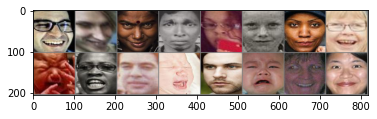

Labels: [tensor(4), tensor(4), tensor(4), tensor(5), tensor(7), tensor(4), tensor(4), tensor(4), tensor(5), tensor(6), tensor(4), tensor(5), tensor(7), tensor(5), tensor(4), tensor(4)]


In [ ]:
# Reference - lab 8
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and print labels
imshow(torchvision.utils.make_grid(images))
first_labels = [label for label in labels]
print('Labels:', first_labels)

In [ ]:
# Reference - https://www.youtube.com/watch?v=pDdP0TFzsoQ
# Reference - Lab 8
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # color channel, i/p, kernel size
        self.pool = nn.MaxPool2d(2, 2) # kernel size and stride size
        self.conv2 = nn.Conv2d(6, 16, 5) # last i/p , 
        self.fc1 = nn.Linear(16 * 22 * 22 , 120) # the resulting images keep getting smaller - (w-f + 2P)/S+1, (100-5+0/2)+1 = ~48
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 22 *22)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# # Reference - Lab 8
net = Net()

# define the loss and the optimizer (needs to be done after moving the network to the GPU!)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [ ]:
# # Reference - https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
# net = Net()
# criterion = nn.CrossEntropyLoss().cuda()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# if torch.cuda.is_available(): ## checking if GPU is available
#     net = net.cuda()
#     criterion = criterion.cuda()
# print(net)

In [ ]:
import time

t0 = time.time()

for epoch in range(10):  # due to time constraint for this coursework, epoch = 10

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 100 == 0:    # print every 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

[1,     1] loss: 0.021
[1,   101] loss: 2.014
[1,   201] loss: 1.740
[1,   301] loss: 1.646
[1,   401] loss: 1.632
[1,   501] loss: 1.584
[1,   601] loss: 1.506
[1,   701] loss: 1.448
[2,     1] loss: 0.017
[2,   101] loss: 1.361
[2,   201] loss: 1.327
[2,   301] loss: 1.330
[2,   401] loss: 1.264
[2,   501] loss: 1.273
[2,   601] loss: 1.232
[2,   701] loss: 1.139
[3,     1] loss: 0.010
[3,   101] loss: 1.091
[3,   201] loss: 1.085
[3,   301] loss: 1.057
[3,   401] loss: 1.011
[3,   501] loss: 1.024
[3,   601] loss: 1.028
[3,   701] loss: 1.027
[4,     1] loss: 0.009
[4,   101] loss: 0.958
[4,   201] loss: 0.918
[4,   301] loss: 0.930
[4,   401] loss: 0.981
[4,   501] loss: 0.910
[4,   601] loss: 0.929
[4,   701] loss: 0.887
[5,     1] loss: 0.010
[5,   101] loss: 0.821
[5,   201] loss: 0.867
[5,   301] loss: 0.839
[5,   401] loss: 0.863
[5,   501] loss: 0.821
[5,   601] loss: 0.896
[5,   701] loss: 0.867
[6,     1] loss: 0.005
[6,   101] loss: 0.752
[6,   201] loss: 0.785
[6,   301] 

In [ ]:
PATH_net = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/Models/Net_model.pt'
torch.save(net.state_dict(), PATH_net)

In [ ]:
# Reference - lab 8
correct = 0
total = 0
with torch.no_grad(): # to avoid backprop at test 
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the test images: {100 * correct / total}%")

Accuracy of the test images: 68.41590612777054%


**AlexNet**

Using a pretrained model to improve the accuracy. Modified the existing codes slightly to implement the model. These codes were inspired from Lab 8

In [ ]:
# Reference - Lab -8, https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/, 
# Reference - https://pytorch.org/vision/0.12/models.html?highlight=alexnet
transform_Alex = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
AlexNet_model = models.alexnet(pretrained=True)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer_Alex = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):
    for i, (images, labels) in enumerate(trainloader):
            AlexNet_model = AlexNet_model.cuda()

            optimizer_Alex.zero_grad()
            outputs = AlexNet_model(images.cuda())
            alex_loss = criterion(outputs.cuda(), labels.cuda())
            alex_loss.backward()
            optimizer_Alex.step()

            if i % 100 == 0:
                print("Loss: {} ".format(alex_loss.data))
                #print('[%d, %5d] loss: %.3f VGG16 Accuracy: %.3f' %(epoch + 1, i + 1, vgg_loss.data,vgg_accuracy ))

Loss: 15.763082504272461 
Loss: 1.5943148136138916 
Loss: 1.456886649131775 
Loss: 1.1791203022003174 
Loss: 0.9795221090316772 
Loss: 0.9155632853507996 
Loss: 0.6989454627037048 
Loss: 0.6780688762664795 
Loss: 1.1454875469207764 
Loss: 0.9996851682662964 
Loss: 0.9872548580169678 
Loss: 0.7565221786499023 
Loss: 1.2037107944488525 
Loss: 1.3448768854141235 
Loss: 0.37167924642562866 
Loss: 0.9218406677246094 
Loss: 0.9050192832946777 
Loss: 0.582157552242279 
Loss: 0.7637956142425537 
Loss: 1.3982751369476318 
Loss: 0.45604848861694336 
Loss: 0.6196199655532837 
Loss: 0.6404497623443604 
Loss: 0.423022985458374 
Loss: 0.36346253752708435 
Loss: 0.29557958245277405 
Loss: 0.5554789304733276 
Loss: 0.6506584882736206 
Loss: 0.38325318694114685 
Loss: 1.012878179550171 
Loss: 0.6709581613540649 
Loss: 0.6666024923324585 
Loss: 0.6350919008255005 
Loss: 0.5130730271339417 
Loss: 0.3993798494338989 
Loss: 0.7478227019309998 
Loss: 0.20490692555904388 
Loss: 0.5931323766708374 
Loss: 0.24

In [ ]:
import pickle

with open("/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/Models/AlexNet_model.pickle", "wb") as a:
    pickle.dump(AlexNet_model, a)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(testloader):

      outputs = AlexNet_model(images.cuda())
      _, predicted = torch.max(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels.cuda()).sum()
alex_accuracy = 100 * correct / float(total)
print("Accuracy: {} % ".format(alex_accuracy))

Accuracy: 75.22815704345703 % 


The accuracy has increased.

**VGG16 Model**

In [ ]:
VGG16_model = models.vgg16(pretrained = True)
criterion = nn.CrossEntropyLoss().cuda()
optimizer_vgg = optim.SGD(VGG16_model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
transform_vgg =   transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
t0 = time.time()
for epoch in range(10):
    for i, (images, labels) in enumerate(trainloader):
            VGG16_model = VGG16_model.cuda()

            optimizer_vgg.zero_grad()
            outputs = VGG16_model(images.cuda())
            vgg_loss = criterion(outputs.cuda(), labels.cuda())
            vgg_loss.backward()
            optimizer_vgg.step()

            if i % 100 == 0:
                print("Loss: {} ".format(vgg_loss.data))
print('Finished Training of VGG16: total time in seconds =', time.time() - t0)


Loss: 0.0797421783208847 
Loss: 0.003823202336207032 
Loss: 0.005825715139508247 
Loss: 0.016498226672410965 
Loss: 0.015418185852468014 
Loss: 0.0004296476545277983 
Loss: 0.006015249993652105 
Loss: 0.22601693868637085 
Loss: 0.1129249855875969 
Loss: 0.010044578462839127 
Loss: 0.08010490238666534 
Loss: 0.004422755446285009 
Loss: 0.05131450667977333 
Loss: 0.13018818199634552 
Loss: 0.0016135555924847722 
Loss: 0.012055394239723682 
Loss: 0.005000676494091749 
Loss: 0.0014264286728575826 
Loss: 0.0005823475657962263 
Loss: 0.0010311437072232366 
Loss: 0.015604519285261631 
Loss: 0.1614893078804016 
Loss: 0.0014447105349972844 
Loss: 0.008684389293193817 
Loss: 0.0005187851493246853 
Loss: 0.002250004792585969 
Loss: 0.08881960064172745 
Loss: 0.0011496018851175904 
Loss: 0.004198542330414057 
Loss: 0.10700267553329468 
Loss: 0.012628620490431786 
Loss: 0.18580415844917297 
Loss: 0.021822907030582428 
Loss: 0.00016469834372401237 
Loss: 0.0005036829970777035 
Loss: 0.01876736432313

In [ ]:
import pickle

with open("/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/Models/VGG_model.pickle", "wb") as f:
    pickle.dump(VGG16_model, f)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(testloader):

      outputs = VGG16_model(images.cuda())
      _, predicted = torch.max(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels.cuda()).sum()
vgg_accuracy = 100 * correct / float(total)
print("Accuracy: {} % ".format(vgg_accuracy))
#print('Accuracy of the network on the test images using Vgg16: %d %%' % vgg_accuracy)

Accuracy: 81.4863052368164 % 


This model has provided the best accuracy.